#### 1.0 import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


2023-03-26 01:46:02.971549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1.1 Loading the Traffic data and Viewing the top 5 of the dataset
This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. The CSV file provides four features:
   - Date time
   - Junctions
   - Vehicles
   - ID
   
The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

In [2]:
df =pd.read_csv('../additional files/')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


#### 1.3 Data Exploration
   - Pharsing dates
   - Ploting time series
   - Feature Engineering for EDA

In [3]:
# Pharsing dates
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Dropping the ID column
df = df.drop(['ID'], axis=1)

# Viewing the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [8]:
# calculate mean and std for each junction
mean = df.groupby('Junction').mean()
std =  df.groupby('Junction').std()

# update index labels to match junction names used in preprocess_data function
mean.index = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']
std.index = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']


## save mean and std to CSV files
mean.to_csv('../additional-files/mean.csv')
std.to_csv('../additional-files/std.csv')

In [12]:
std

,Vehicles
Junction 1,23.008345
Junction 2,7.401307
Junction 3,10.436005
Junction 4,3.521455


In [11]:
mean

,Vehicles
Junction 1,45.052906
Junction 2,14.253221
Junction 3,13.694010
Junction 4,7.251611


#### 1.4 Exploratory Data Analysis

Text(0.5, 0, 'Date')

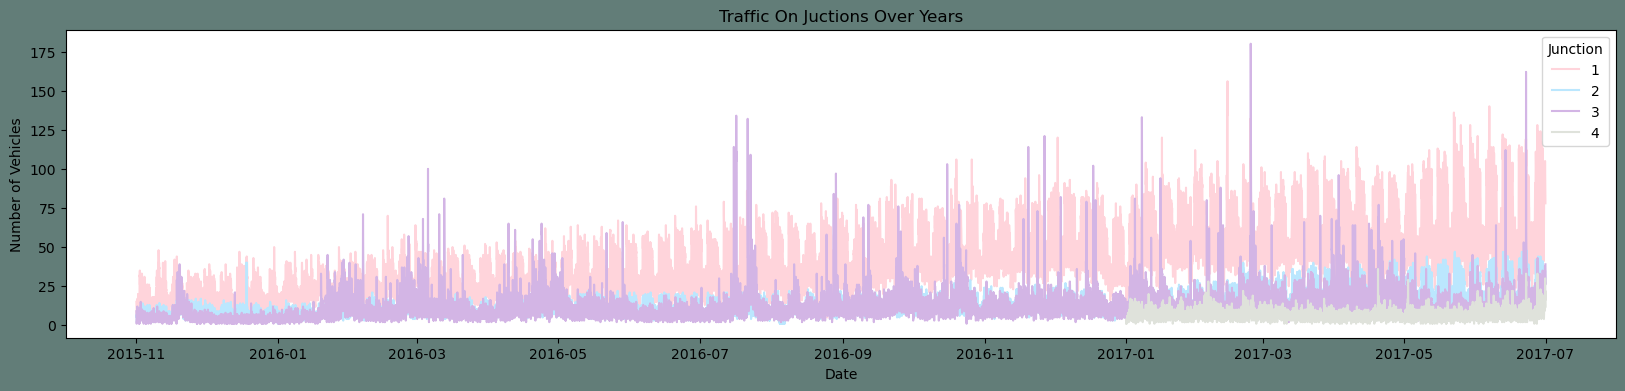

In [7]:
# Passing a list of colors to be used for 
colors = ['#FFD4DB', '#BBE7FE','#D3B5E5','#DFE2DB']
# Ploting the Timeseries
plt.figure(figsize=(20,4) , facecolor='#627D78')
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)

# labelling the axes
Time_series.set_title("Traffic On Juctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

#### Expected output: Noticeable information in the above plot:
    - It can be seen here that the first junction is visibly having an upward trend.
    - The data for the fourth junction is sparse starting only after 2017
    - Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.

#### 1.5 Feature Engineering
    - Year
    - Month
    - Date in the given month
    - Hour

In [8]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


#### 1.5 Exploratory Data Analysis
    - Plotting the newly created features

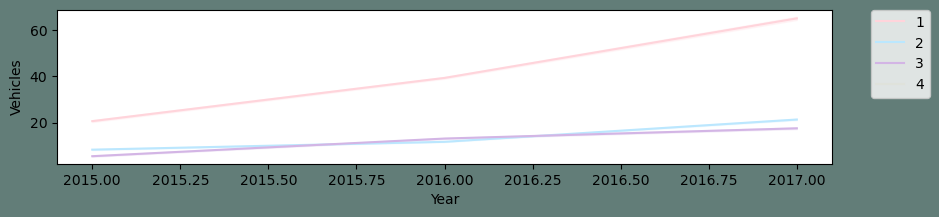

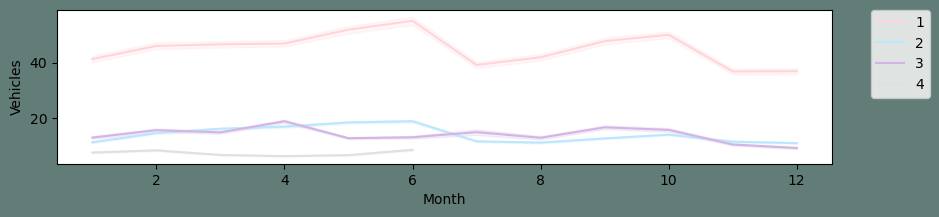

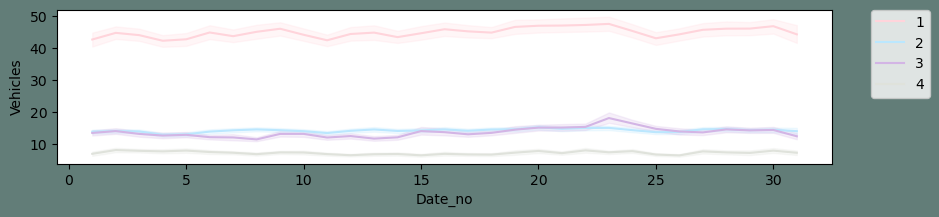

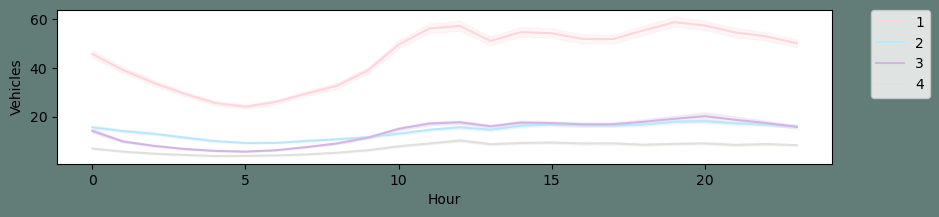

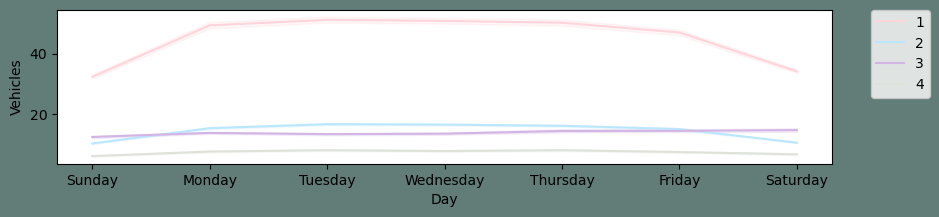

In [9]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

##### From the above plot following things can be concluded:

- Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

- We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same.

- Monthly, throughout all the dates there is a good consistency in data.

- For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation.

- For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.

Text(0.5, 0, 'Date')

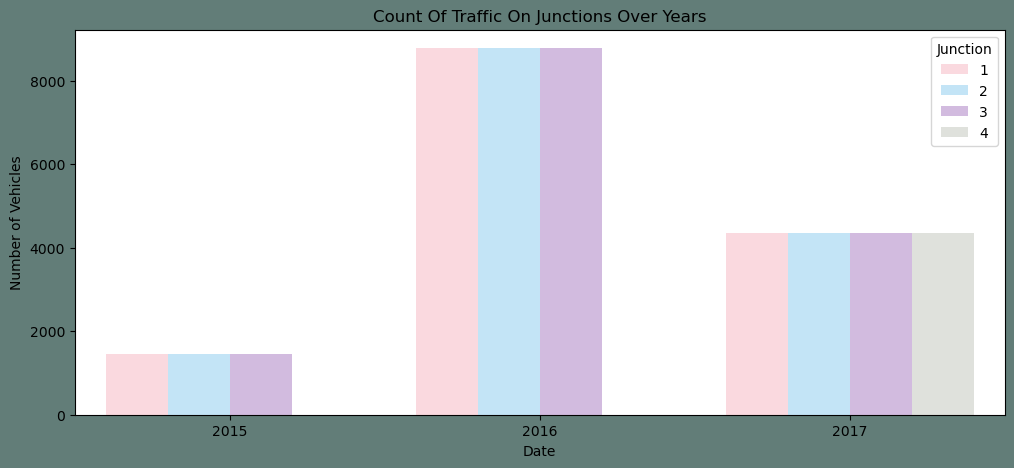

In [10]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

#### The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month.

<Axes: >

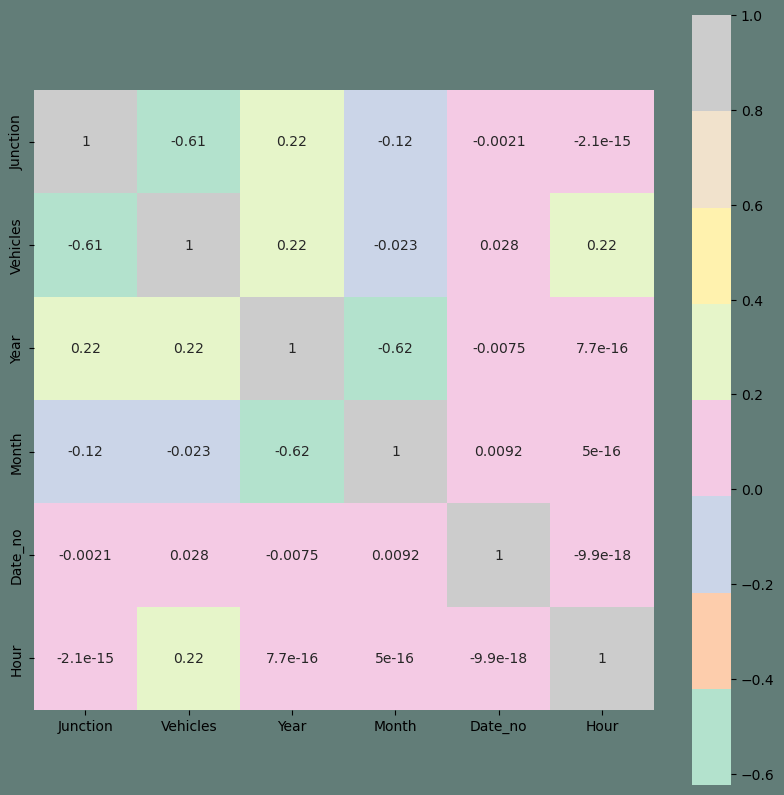

In [11]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

###### The highest correlation is certainly with the preexisting feature.

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data.

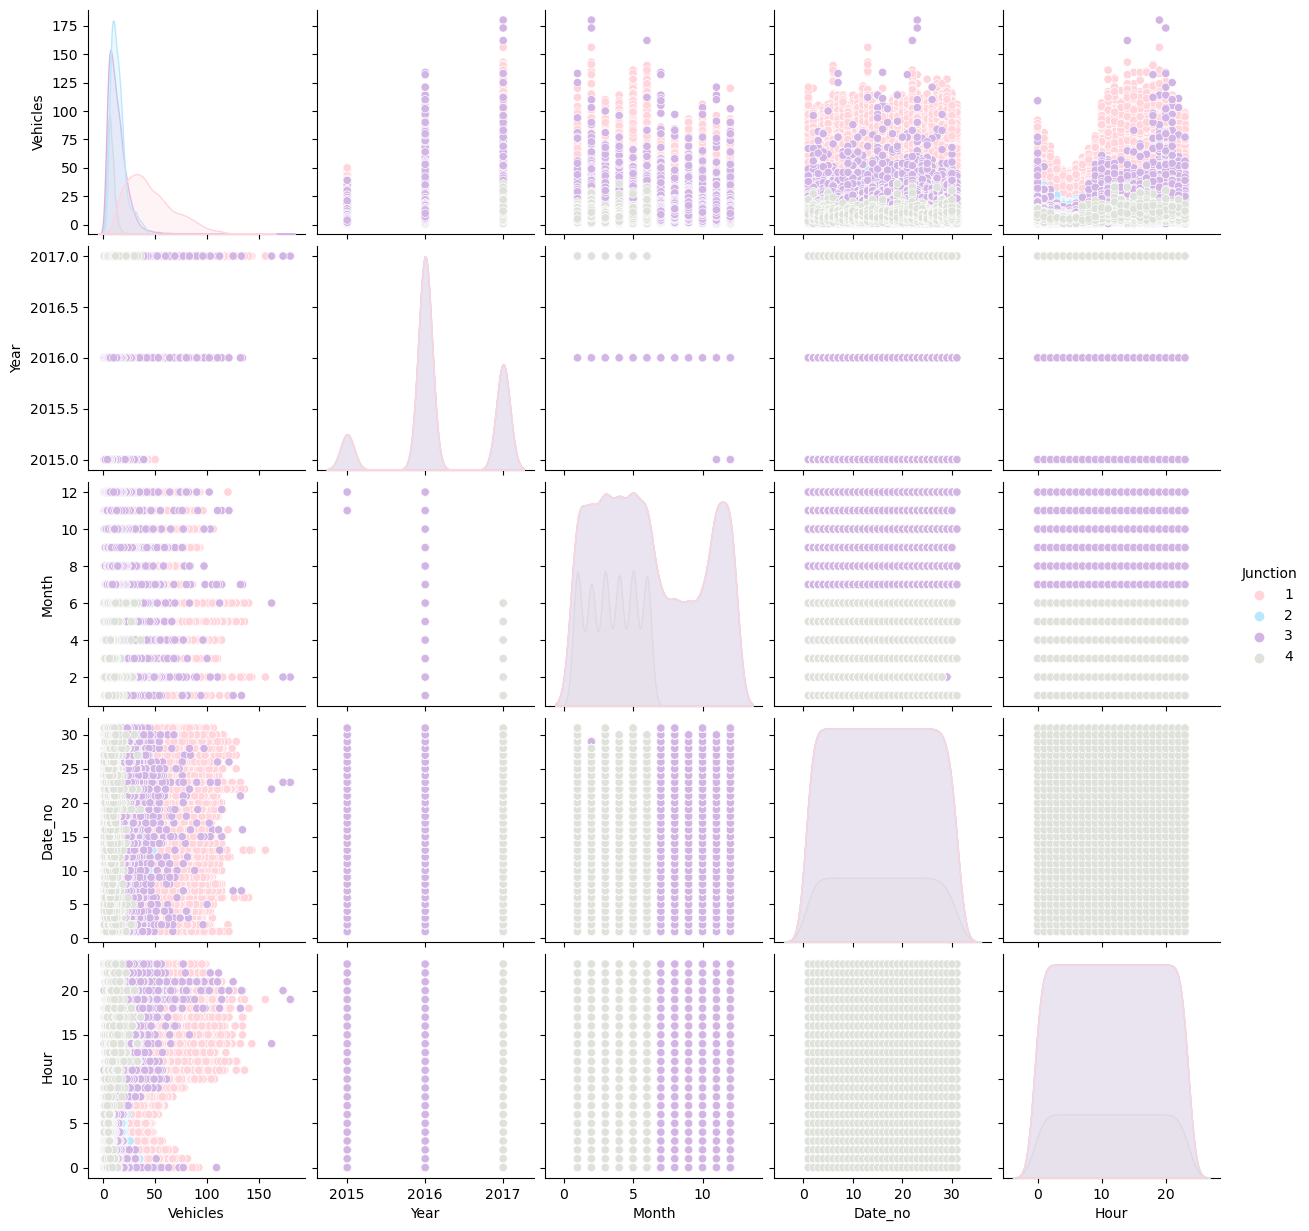

In [12]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

##### Conclusions that I have come to draw after this EDA

- The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
- The yearly trend for Junctions one, two and three have diffrent slopes.

Junction number one has a more strong weekly seasonality in comparison to the other junctions.
For the above-postulated reasons, I think that junctions must be transformed as per their individual needs.

#### 1.6 Data Transformation and Preprocessing

#### In this step I will be following the subsequent order:

- Creating different frames for each Junction and plotting them
- Transforming the series and plotting them
- Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
- Creating test and train sets

In [13]:
#Pivoting data fron junction 
df_J = df.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                                   Year  \
Junction             1             2             3            4             1   
count     14592.000000  14592.000000  14592.000000  4344.000000  14592.000000   
mean         45.052906     14.253221     13.694010     7.251611   2016.197368   
std          23.008345      7.401307     10.436005     3.521455      0.599247   
min           5.000000      1.000000      1.000000     1.000000   2015.000000   
25%          27.000000      9.000000      7.000000     5.000000   2016.000000   
50%          40.000000     13.000000     11.000000     7.000000   2016.000000   
75%          59.000000     17.000000     18.000000     9.000000   2017.000000   
max         156.000000     48.000000    180.000000    36.000000   2017.000000   

                                                     Month                \
Junction             2             3       4             1             2   
count     14592.000000  14592.000000  4344.0  14592.000000  14592.000000   
mean       2016.197368   2016.197368  2017.0      6.120066      6.120066   
std           0.599247      0.599247     0.0      3.619842      3.619842   
min        2015.000000   2015.000000  2017.0      1.000000      1.000000   
25%        2016.000000   2016.000000  2017.0      3.000000      3.000000   
50%        2016.000000   2016.000000  2017.0      6.000000      6.000000   
75%        2017.000000   2017.000000  2017.0     10.000000     10.000000   
max        2017.000000   2017.000000  2017.0     12.000000     12.000000   

                                          Date_no                              \
Junction             3            4             1             2             3   
count     14592.000000  4344.000000  14592.000000  14592.000000  14592.000000   
mean          6.120066     3.508287     15.710526     15.710526     15.710526   
std           3.619842     1.710157      8.789036      8.789036      8.789036   
min           1.000000     1.000000      1.000000      1.000000      1.000000   
25%           3.000000     2.000000      8.000000      8.000000      8.000000   
50%           6.000000     4.000000     16.000000     16.000000     16.000000   
75%          10.000000     5.000000     23.000000     23.000000     23.000000   
max          12.000000     6.000000     31.000000     31.000000     31.000000   

                               Hour                                           
Junction            4             1             2             3            4  
count     4344.000000  14592.000000  14592.000000  14592.000000  4344.000000  
mean        15.602210     11.500000     11.500000     11.500000    11.500000  
std          8.736328      6.922424      6.922424      6.922424     6.922983  
min          1.000000      0.000000      0.000000      0.000000     0.000000  
25%          8.000000      5.750000      5.750000      5.750000     5.750000  
50%         16.000000     11.500000     11.500000     11.500000    11.500000  
75%         23.000000     17.250000     17.250000     17.250000    17.250000  
max         31.000000     23.000000     23.000000     23.000000    23.000000

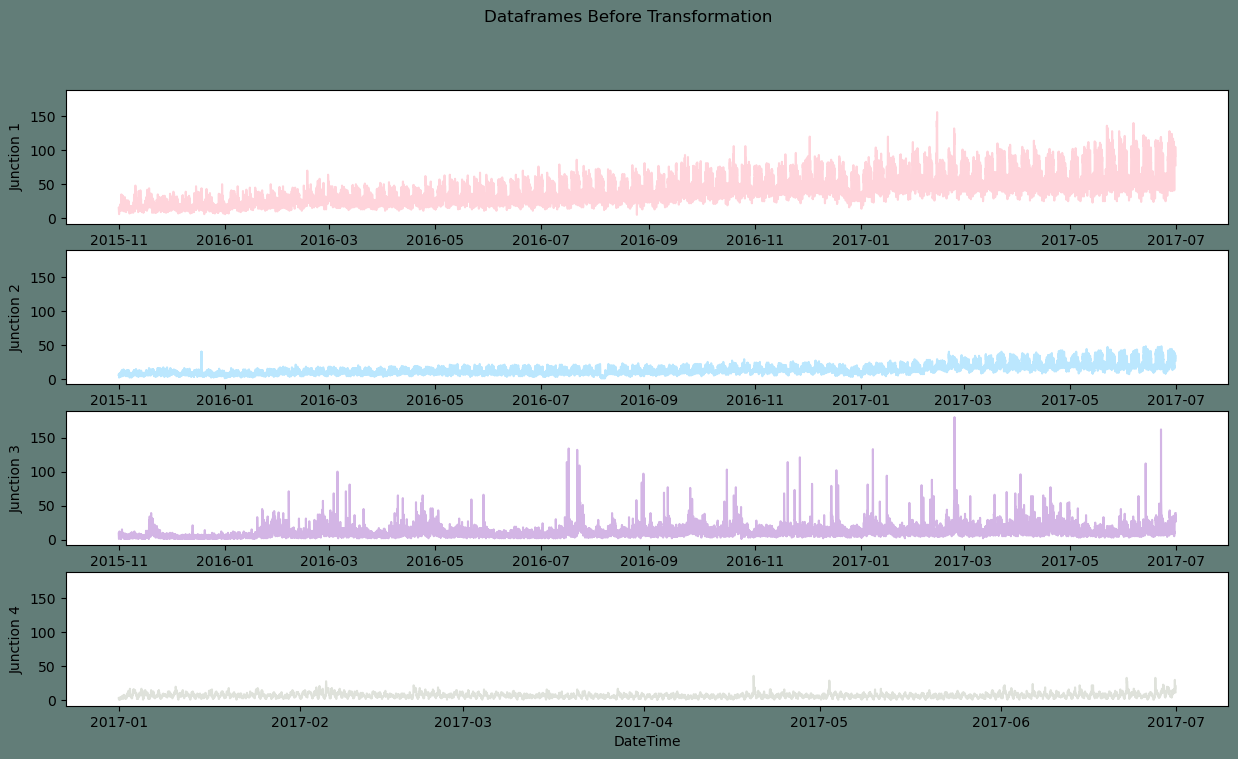

In [14]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

##### Steps for Transforming:

- Normalizing
- Differencing

In [15]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:

- For Junction one, I will be taking a difference of weekly values.
- For junction two, The difference of consecutive days is a better choice
- For Junctions three and four, the difference of the hourly values will serve the purpose.

In [16]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

#### Plots of Transformed Dataframe


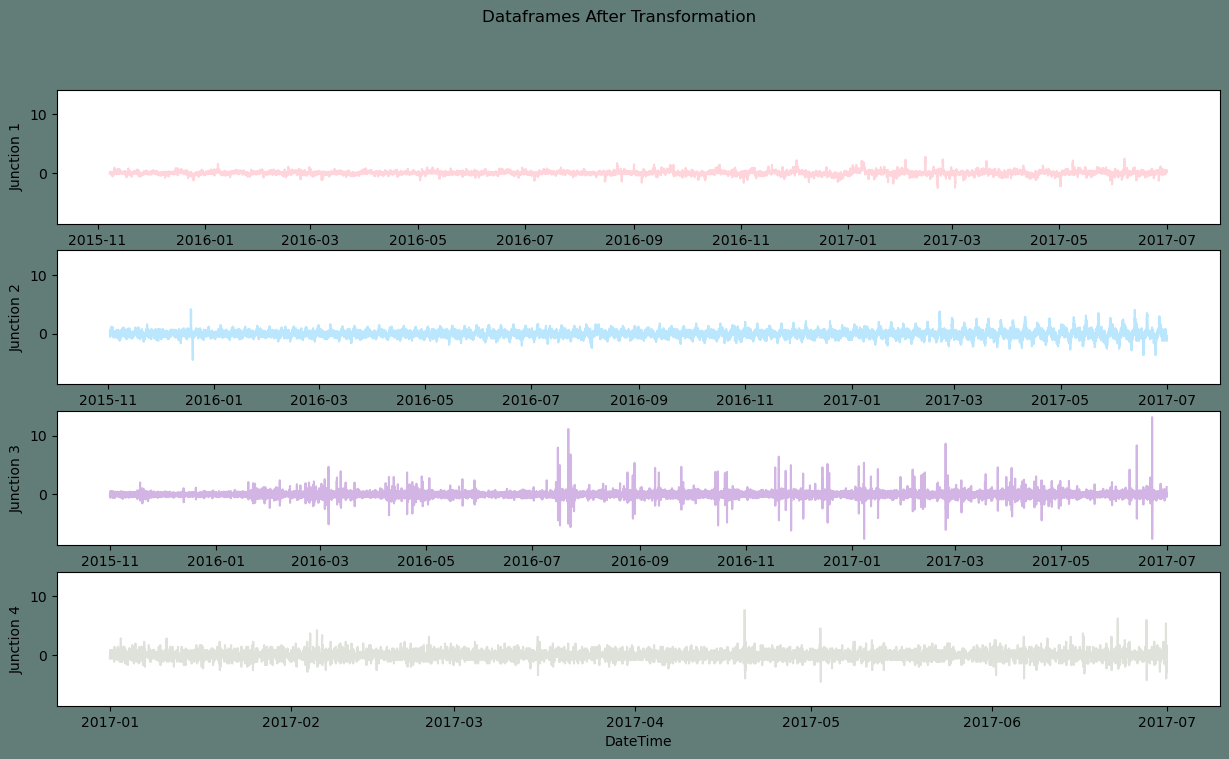

In [17]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test.

In [18]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415548
p-value: 4.798539876395171e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940133
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832824
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052266
p-value: 2.7787875325955e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


#### Now that the data is stationary, preprocessing the data for the neural net by:

- Splitting the test train sets
- Assigning X as features and y as target
- Reshaping data for neural net

In [19]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

#### 1.7 Model Building
For this project, I have settled to use Gated Recurrent Unit (GRU). In this section, I am creating a function for the neural net to call on and fit the data frames for all four junctions.



In [20]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    
    model.save('model.h5') # save the trained model to a file

    pred_GRU= model.predict(X_Test)

    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()


#### 1.8 Fitting The Model

Now, I will be fitting the transformed training sets of four junctions to the model created and compare them to the transformed test sets.


##### Fitting the first junction and plotting the predictions and testset


In [21]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

2023-03-25 18:08:42.846294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 18:08:42.846654: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
87/87 [==============================] - 95s 931ms/step - loss: 0.0755
Epoch 2/50
87/87 [==============================] - 88s 1s/step - loss: 0.0664
Epoch 3/50
87/87 [==============================] - 104s 1s/step - loss: 0.0645
Epoch 4/50
87/87 [==============================] - 86s 991ms/step - loss: 0.0630
Epoch 5/50
87/87 [==============================] - 94s 1s/step - loss: 0.0619
Epoch 6/50
87/87 [==============================] - 93s 1s/step - loss: 0.0610
Epoch 7/50
87/87 [==============================] - 99s 1s/step - loss: 0.0604
Epoch 8/50
87/87 [==============================] - 95s 1s/step - loss: 0.0590
Epoch 9/50
87/87 [==============================] - 78s 894ms/step - loss: 0.0587
Epoch 10/50
87/87 [==============================] - 77s 880ms/step - loss: 0.0574
Epoch 11/50
87/87 [==============================] - 75s 856ms/step - loss: 0.0569
Epoch 12/50
87/87 [==============================] - 69s 796ms/step - loss: 0.0570
Epoch 13/50
87/87 [===========

87/87 [==============================] - 66s 751ms/step - loss: 0.0494
Epoch 33/50
87/87 [==============================] - 66s 759ms/step - loss: 0.0495
Epoch 34/50
87/87 [==============================] - 66s 755ms/step - loss: 0.0488
Epoch 35/50
87/87 [==============================] - 64s 741ms/step - loss: 0.0493
Epoch 36/50
87/87 [==============================] - 66s 751ms/step - loss: 0.0495
Epoch 37/50
87/87 [==============================] - 63s 722ms/step - loss: 0.0491
Epoch 38/50
87/87 [==============================] - 62s 712ms/step - loss: 0.0491
Epoch 39/50
87/87 [==============================] - 64s 739ms/step - loss: 0.0488
Epoch 40/50
87/87 [==============================] - 64s 730ms/step - loss: 0.0488
Epoch 41/50
87/87 [==============================] - 62s 717ms/step - loss: 0.0488
Epoch 42/50
87/87 [==============================] - 63s 724ms/step - loss: 0.0490
Epoch 43/50
87/87 [==============================] - 75s 859ms/step - loss: 0.0490
Epoch 44/50
87/8

The root mean squared error is 0.25073993680043843.


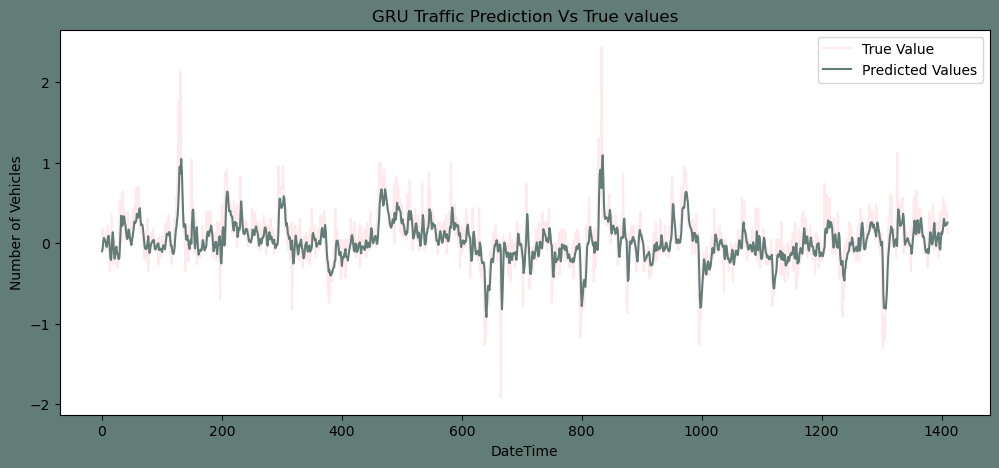

In [22]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

#### 1.9 Fitting the Second Junction and Plotting the Predictions and testset

In [23]:
# Prediction for Second Junction
PredJ2 = GRU_model(X_trainJ2, y_trainJ2, X_testJ2)

Epoch 1/50
88/88 [==============================] - 75s 716ms/step - loss: 0.2409
Epoch 2/50
88/88 [==============================] - 67s 759ms/step - loss: 0.2057
Epoch 3/50
88/88 [==============================] - 64s 723ms/step - loss: 0.1995
Epoch 4/50
88/88 [==============================] - 73s 828ms/step - loss: 0.1968
Epoch 5/50
88/88 [==============================] - 66s 751ms/step - loss: 0.1959
Epoch 6/50
88/88 [==============================] - 42s 471ms/step - loss: 0.1924
Epoch 7/50
88/88 [==============================] - 66s 758ms/step - loss: 0.1938
Epoch 8/50
88/88 [==============================] - 71s 802ms/step - loss: 0.1907
Epoch 9/50
88/88 [==============================] - 66s 749ms/step - loss: 0.1890
Epoch 10/50
88/88 [==============================] - 67s 763ms/step - loss: 0.1902
Epoch 11/50
88/88 [==============================] - 96s 1s/step - loss: 0.1891
Epoch 12/50
88/88 [==============================] - 76s 861ms/step - loss: 0.1879
Epoch 13/50
88/8

Epoch 32/50
88/88 [==============================] - 79s 890ms/step - loss: 0.1826
Epoch 33/50
88/88 [==============================] - 80s 907ms/step - loss: 0.1823
Epoch 34/50
88/88 [==============================] - 76s 856ms/step - loss: 0.1835
Epoch 35/50
88/88 [==============================] - 72s 820ms/step - loss: 0.1841
Epoch 36/50
88/88 [==============================] - 71s 804ms/step - loss: 0.1823
Epoch 37/50
88/88 [==============================] - 78s 889ms/step - loss: 0.1848
Epoch 38/50
88/88 [==============================] - 79s 900ms/step - loss: 0.1833
Epoch 39/50
88/88 [==============================] - 79s 899ms/step - loss: 0.1825
Epoch 40/50
88/88 [==============================] - 79s 901ms/step - loss: 0.1830
Epoch 41/50
88/88 [==============================] - 81s 923ms/step - loss: 0.1824
Epoch 42/50
88/88 [==============================] - 77s 873ms/step - loss: 0.1814
Epoch 43/50
88/88 [==============================] - 78s 883ms/step - loss: 0.1825
Epoc

The root mean squared error is 0.5545531316934766.


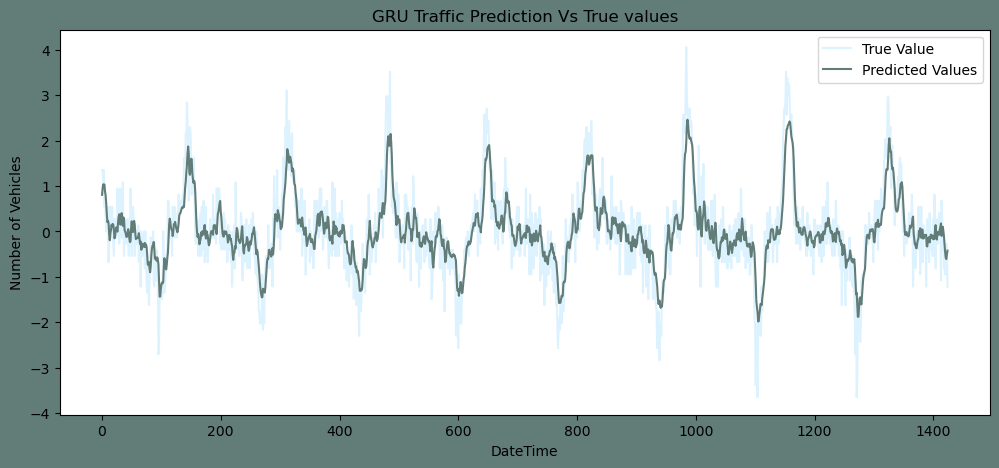

In [24]:
# Results for J2
RMSE_J2 = RMSE_Value(y_testJ2, PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

#### 2.0: Fitting the third junction and plotting the prediction and testset

In [25]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)

Epoch 1/50
88/88 [==============================] - 86s 845ms/step - loss: 0.3036
Epoch 2/50
88/88 [==============================] - 79s 901ms/step - loss: 0.2977
Epoch 3/50
88/88 [==============================] - 78s 880ms/step - loss: 0.2913
Epoch 4/50
88/88 [==============================] - 82s 926ms/step - loss: 0.2913
Epoch 5/50
88/88 [==============================] - 101s 1s/step - loss: 0.2922
Epoch 6/50
88/88 [==============================] - 103s 1s/step - loss: 0.2896
Epoch 7/50
88/88 [==============================] - 93s 1s/step - loss: 0.2879
Epoch 8/50
88/88 [==============================] - 88s 1000ms/step - loss: 0.2878
Epoch 9/50
88/88 [==============================] - 88s 997ms/step - loss: 0.2855
Epoch 10/50
88/88 [==============================] - 77s 873ms/step - loss: 0.2861
Epoch 11/50
88/88 [==============================] - 78s 883ms/step - loss: 0.2850
Epoch 12/50
88/88 [==============================] - 81s 923ms/step - loss: 0.2832
Epoch 13/50
88/88 [

88/88 [==============================] - 52s 589ms/step - loss: 0.2738
Epoch 33/50
88/88 [==============================] - 50s 565ms/step - loss: 0.2693
Epoch 34/50
88/88 [==============================] - 51s 580ms/step - loss: 0.2692
Epoch 35/50
88/88 [==============================] - 54s 614ms/step - loss: 0.2695
Epoch 36/50
88/88 [==============================] - 53s 601ms/step - loss: 0.2656
Epoch 37/50
88/88 [==============================] - 51s 576ms/step - loss: 0.2682
Epoch 38/50
88/88 [==============================] - 49s 559ms/step - loss: 0.2670
Epoch 39/50
88/88 [==============================] - 49s 553ms/step - loss: 0.2651
Epoch 40/50
88/88 [==============================] - 60s 678ms/step - loss: 0.2682
Epoch 41/50
88/88 [==============================] - 59s 674ms/step - loss: 0.2676
Epoch 42/50
88/88 [==============================] - 59s 666ms/step - loss: 0.2661
Epoch 43/50
88/88 [==============================] - 53s 605ms/step - loss: 0.2662
Epoch 44/50
88/8

The root mean squared error is 0.6126168523349318.


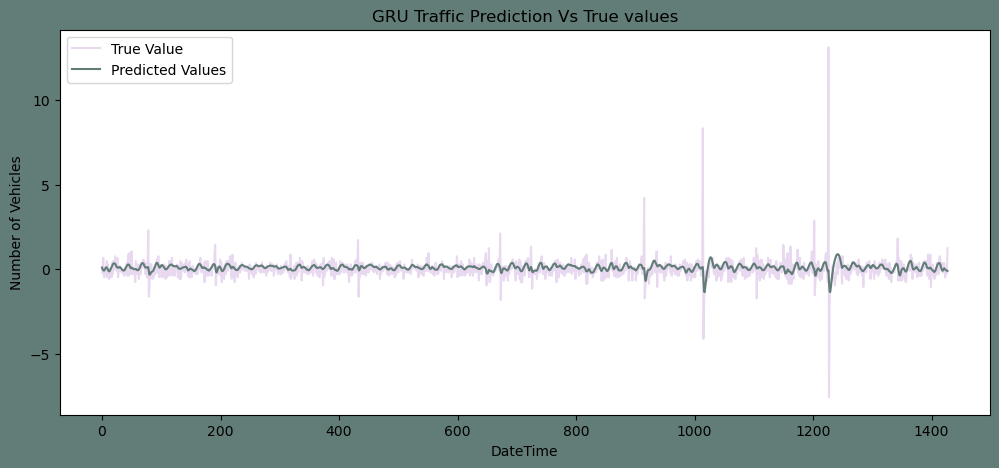

In [26]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

#### 2.1 

In [27]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - 27s 620ms/step - loss: 0.6927
Epoch 2/50
26/26 [==============================] - 17s 644ms/step - loss: 0.6902
Epoch 3/50
26/26 [==============================] - 19s 723ms/step - loss: 0.6890
Epoch 4/50
26/26 [==============================] - 18s 700ms/step - loss: 0.6880
Epoch 5/50
26/26 [==============================] - 20s 754ms/step - loss: 0.6847
Epoch 6/50
26/26 [==============================] - 14s 541ms/step - loss: 0.6849
Epoch 7/50
26/26 [==============================] - 14s 535ms/step - loss: 0.6846
Epoch 8/50
26/26 [==============================] - 16s 636ms/step - loss: 0.6863
Epoch 9/50
26/26 [==============================] - 15s 593ms/step - loss: 0.6883
Epoch 10/50
26/26 [==============================] - 20s 771ms/step - loss: 0.6814
Epoch 11/50
26/26 [==============================] - 17s 661ms/step - loss: 0.6780
Epoch 12/50
26/26 [==============================] - 16s 624ms/step - loss: 0.6779
Epoch 13/50
2

Epoch 32/50
26/26 [==============================] - 17s 635ms/step - loss: 0.6620
Epoch 33/50
26/26 [==============================] - 15s 569ms/step - loss: 0.6564
Epoch 34/50
26/26 [==============================] - 18s 697ms/step - loss: 0.6549
Epoch 35/50
26/26 [==============================] - 15s 566ms/step - loss: 0.6475
Epoch 36/50
26/26 [==============================] - 17s 663ms/step - loss: 0.6536
Epoch 37/50
26/26 [==============================] - 17s 656ms/step - loss: 0.6484
Epoch 38/50
26/26 [==============================] - 14s 524ms/step - loss: 0.6389
Epoch 39/50
26/26 [==============================] - 14s 528ms/step - loss: 0.6481
Epoch 40/50
26/26 [==============================] - 16s 601ms/step - loss: 0.6369
Epoch 41/50
26/26 [==============================] - 15s 575ms/step - loss: 0.6200
Epoch 42/50
26/26 [==============================] - 15s 587ms/step - loss: 0.6147
Epoch 43/50
26/26 [==============================] - 16s 610ms/step - loss: 0.6084
Epoc

The root mean squared error is 1.0084641466237143.


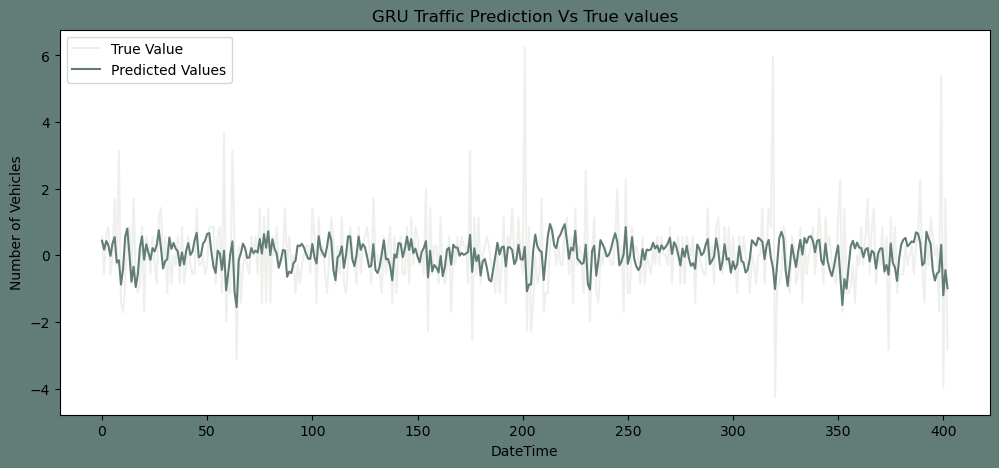

In [28]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

#### 2.1 : Inversing the Transformation of data

Applying inversing transformation to remove seasonality and trends, Performing this step will make the prediction back to accurate scale

In [29]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

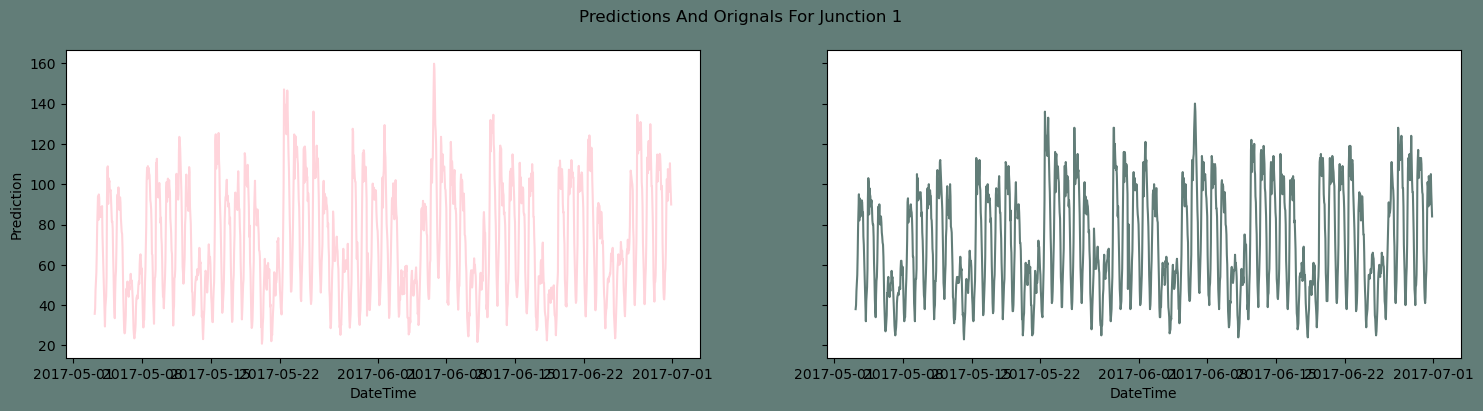

In [30]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Predictions And Orignals For Junction 1", 0)


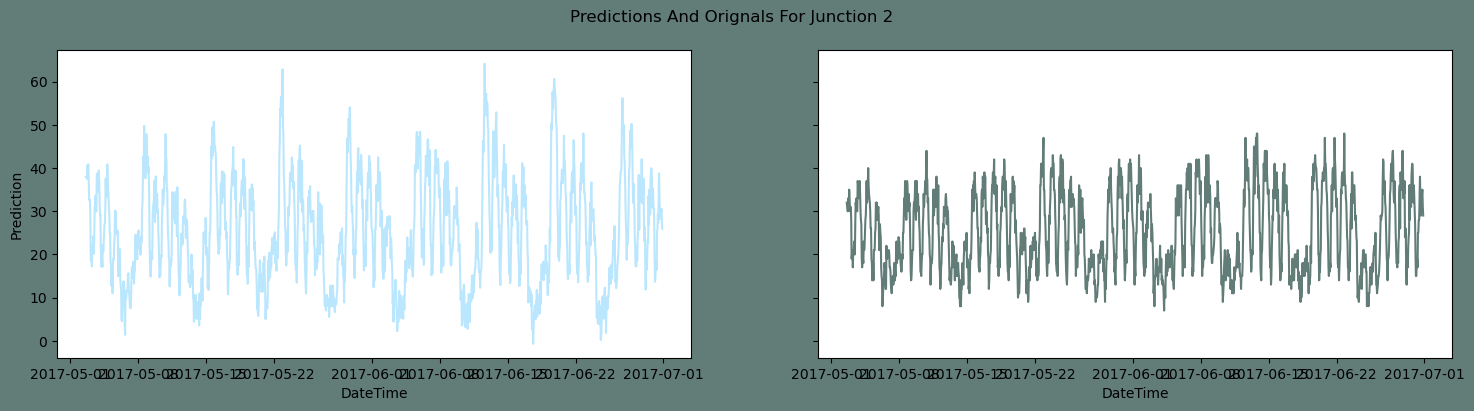

In [31]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Predictions And Orignals For Junction 2", 1)

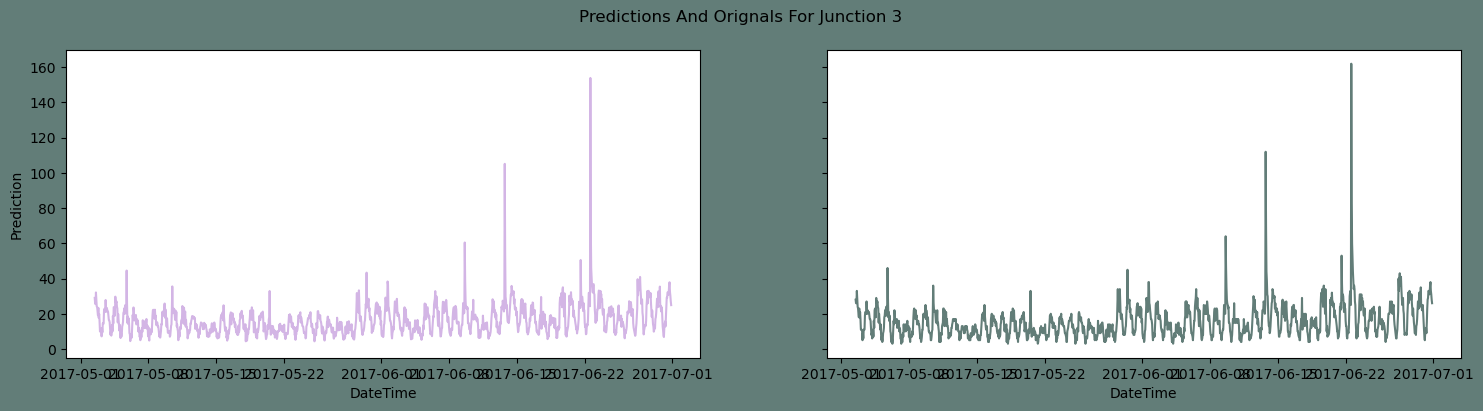

In [32]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Predictions And Orignals For Junction 3", 2)

#### The inverse transform on the fourth junction

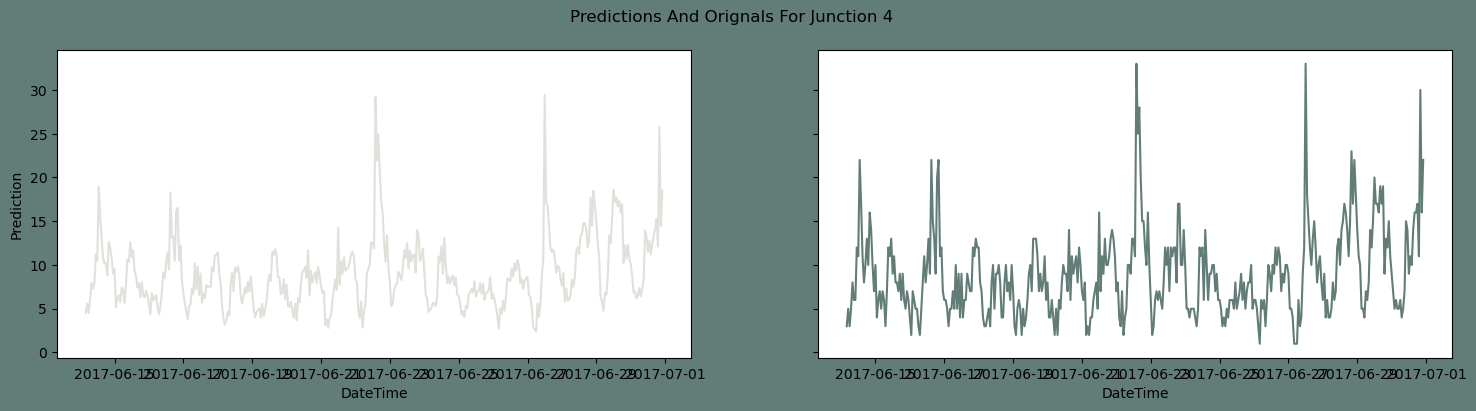

In [33]:

#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Predictions And Orignals For Junction 4", 3)

#### Summary

In this notebook, I have trained GRU Neural Network to Predict traffic on four junctions. I used Normalization and Differencing transformation to achieve a stationary time seriess. As the Junction varying in trends and seasonality, i took different approach for each junction to make it stationary. I applied the root mean squared error as the evalution metric for the model. In addition to that, i have plotted the Prediction alongside the original test value.Take aways from the data analysis;

The number of vehicles in junction one is rising more rapidly compared to junction two and three. The Sparsity of the data in junction four bars me from making any conclusion on the same

The junction one's traffic has a stronger weekly seasonlity as well as hourly seasonality. Where as other junction are significantly linear